# ltest

Load test axisymmetric or strip shallow foundations subjected to vertical, horizontal or flexural static and dynamic loads in [Plaxis 2D](https://www.bentley.com/software/plaxis-2d/#:~:text=PLAXIS%20is%20a%20computer%20application,code%20of%20the%20software%20application.).

## License

Distributed under the MIT License. See LICENSE.txt for more information.

## Acknowledgments

`ltest` is developed by Pablo Barbieri. Professor Timothy Newson provides the technical overview of the project.

This work was supported by the Natural Sciences and Engineering Research Council of Canada (Grant #: RGPIN-2020-06713).

### Contact

You can reach Pablo Barbieri at pbarbie2@uwo.ca.

## Change log

- 2023-10-31 -- 0.0.1:
    - First release.


- 2023-11-05 -- 0.0.2: 
    - Added model_type to README. 
    - Complete docstrings.
    - Fixed compression positive, pull-out positive flags in test plot.
    - 5-node elements supported.
    - Model size set at creation in Plaxis.
 

- 2023-12-01 -- 0.0.3: 
    - Non-symmetric foundation geometry
    - Start phase selection in tests
    - Rayleigh alpha & beta in materials
    - User configurable deformation and dynamic boundary conditions
    - Safety test and plot
    - Dynamic test and plot
    - Shake test and plot
    - Surface load
    - Updated README

## Getting started

### Requirements

``ltest`` can either be used within the Plaxis [remote scripting Python wrap](https://communities.bentley.com/products/geotech-analysis/w/wiki/46005/using-plaxis-remote-scripting-with-the-python-wrapper) or in a regular Python environment. ``ltest`` requires [pandas](https://pandas.pydata.org/docs/index.html) which is not included by default in Plaxis Python environment. To install it, or any other package, follow the instructions listed on [Plaxis site](https://communities.bentley.com/products/geotech-analysis/w/wiki/51822/how-to-install-additional-python-modules-in-plaxis).

To use ``ltest`` in a custom Python environment, the ``plxscripting`` package must be installed in that environment along all other required packages. ``plxscripting`` cannot be installed using conda or pip. Instead, it must be installed following the [these instructions](https://communities.bentley.com/products/geotech-analysis/w/wiki/51822/how-to-install-additional-python-modules-in-plaxis).

> **Warning**<br>
Beware that ``plxscripting`` requires Python 3.7. **It will crash with later versions.**

### Installation

Clone the repo:

`git clone https://github.com/p-barb/ltest`

## Usage

### Plaxis connection

Along with ``ltest`` you will need to import ``plxscripting`` and connect with Plaxis following [these instructions](https://communities.bentley.com/products/geotech-analysis/w/wiki/46005/using-plaxis-remote-scripting-with-the-python-wrapper).

In [1]:
from plxscripting.easy import *
import ltest 

password = "nicFgr^TtsFm~h~M"
localhostport_input = 10000 
localhostport_output = 10001
s_i, g_i = new_server('localhost', localhostport_input, password=password) 
s_o, g_o = new_server('localhost', localhostport_output, password=password)

> **Warning**<br>
**This code will not be repeated in every example, but it is assumed it was executed**.

### Create foundation model

> **Warning**  
The model units are **kN** and **m** by default.

The [geometry](#Geometry) of the foundation is given by:

In [3]:
d = 1.2 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

[Materials](#Materials) are defined by dictionaries containing the properties required in each case by Plaxis. [Linear-Elastic](#Linear-elastic), [Mohr-Coulomb](#Mohr-Coulomb) and [Hardening Soil (HS)](#Hardening-soil) soil materials are supported. A Mohr-Coulomb material is used for the soil:

In [4]:
# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg
soil['Rinter'] = 0 # interface strenght

The foundation itself is modeled by plate elements. The `concrete` method generates the dictionary with the [plate material](#Plate-materials) properties from the desired compressive strength, unit weight and plate thickness.

In [5]:
# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

Create an [axisymmetric foundation](#Model-types) model using plate elements for the column and footing:

In [5]:
model = ltest.SPlate(s_i, g_i, g_o, b, d, soil, footing, column)

The resulting model geometry can be inspected visually in python:

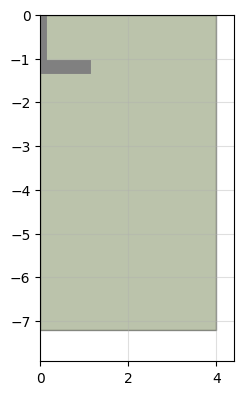

In [6]:
model.plot()

### Test

[Static](#Load-test), [failure](#Failure-test), [safety](#Safety-test), [dynamic loading](#Dynamic-load-test) and [earthquake shake](#Shake-test) tests are available. A static load test is conducted using the ``load_test`` method. The test consist in consecutive load levels being applied to the foundation. Negative loads imply compression, while positive pull-out. Each load level is a phase where the load is set to the provided value.

In [7]:
testid = 'test A'
load = [-60, 0, -60] #kN
model.load_test(testid, load)

Calculation results are stored in a dataframe:

In [9]:
model._results

,test,phase,previous,plx id,previous plx id,location,step,time,sumMstage,SumMsf,...,Fy,Fx,M,qy0,qy1,qx,Fy target,Fx target,M target,ratchetting
0,None,construction,None,Phase_1,None,top,1.0,None,0.500000,None,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False
1,None,construction,None,Phase_1,None,top,2.0,None,1.000000,None,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False
2,None,construction,None,Phase_1,None,0.0,1.0,None,0.500000,None,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False
3,None,construction,None,Phase_1,None,0.0,2.0,None,1.000000,None,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False
4,None,construction,None,Phase_1,None,0.25,1.0,None,0.500000,None,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1.0,63.0,0.0,0.983677,1.0,...,-59.020600,0.0,0.0,0.0,0.0,0.0,-59.020600,0.0,0.0,False
1490,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1.0,64.0,0.0,0.987982,1.0,...,-59.278897,0.0,0.0,0.0,0.0,0.0,-59.278897,0.0,0.0,False
1491,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1.0,65.0,0.0,0.992287,1.0,...,-59.537194,0.0,0.0,0.0,0.0,0.0,-59.537194,0.0,0.0,False
1492,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1.0,66.0,0.0,0.996591,1.0,...,-59.795487,0.0,0.0,0.0,0.0,0.0,-59.795487,0.0,0.0,False


By default 6 points are selected surveyed. The load application point at the surface, and points located at the foundation level at a distance of 0, 0.25, 0.5, 0.75 and 1 times b/2. The load test results can be inspected using the ``plot_test`` function.

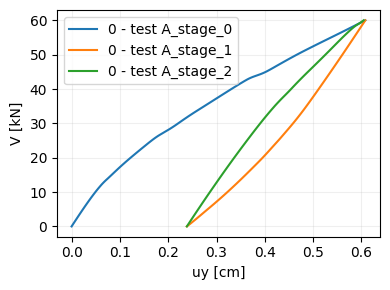

In [8]:
model.plot_test('test A', location=0, legend=True)

Multiple load tests can be performed in the same model.Each load test will start from the construction phase. **

### Save/Load

Saving a model wipes out the Plaxis objects stored in it. This prevents the load test object from further communicating with Plaxis, so no additional can be performed. The information regarding the model geometry, material properties and test results is preserved.

In [10]:
model.save('exmaple_model.mdl')

WARNIGN: Saving the load test to memory whipes out the Plaxis objects. Test results and input parameters will still be avaiable, but no further interaction with Plaxis will be possible. The model can be restored with the <regen> method, but load tests will have to be recalculated to access the results whitin Plaxis.

 Do you whish to proceed: [Y/n] y


The `regen` method regenerates the Plaxis model from a saved model so it can be used to calculate new tests. It can also recalculate the saved tests by setting the argument `test` to `True`. 

In [11]:
model = ltest.load('exmaple_model.mdl')
model.regen(s_i, g_i, g_o, test=True)

### General model settings

The `model_type` argument can be set to `'axisymmetry'` (default) or `'planestrain'`. Also, the title and comments of the model in Plaxis can be set with the `title` and `comments` arguments.

In [12]:
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column,
                    model_type='planestrain', title='plane strain',
                    comments='This is a plane strain model example.')

### Boundary conditions

The `deformation_boundary_condition` argument imposes user defined deformation boundary conditions to the model. A dictionary must be provided with some, or all, of the fields `'XMin'`, `'XMax'`, `'YMin'` or `'YMax'`. Supported values are `"Free"`,  `"Normally fixed"`,  `"Horizontally fixed"`, `"Vertically fixed"` and `"Fully fixed"`. If a boundary is not specified by the user, the default value is adopted.

The `dynamic_boundary_condtions` argument imposes user defined dynamic boundary conditions to the model to be used in a [dynamic load test](#Dynamic-load-test). A dictionary must be provided with some, or all, of the fields `'XMin'`, `'XMax'`, `'YMin'` or `'YMax'`. Supported values are `"None"` and `"Viscous"`. If a boundary is not specified by the user, the default value is adopted.

The `shake_boundary_condtions` argument imposes user defined dynamic boundary conditions to the model to be used in a [shake test](#Shake-test). A dictionary must be provided with some, or all, of the fields `'XMin'`, `'XMax'`, `'YMin'` or `'YMax'`. Supported values are `"None"`, `"Viscous"` and `"Free-field"` . If a boundary is not specified by the user, the default value is adopted.

In [8]:
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column,
                    deformation_boundary_condition={'XMin':'Fully fixed',
                                                    'YMax':'Horizontally fixed'},
                    dynamic_boundary_condtions={'XMin':'Viscous'})

### Element type

The `element_type` argument controls the type of elements used in the model. It can be set to `'6-Noded'` or `'15-Noded'`. By default 15-noded elements are used.

In [9]:
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column,
                    element_type='6-Noded')

### Preliminary model check

Waiting for Plaxis to build and run the initial phases can be time consuming only to check that the model has the correct geometry. The `build` attribute controls whether the Plaxis model gets build. By setting it to `False` the geometry can be inspecting with `plot()`.

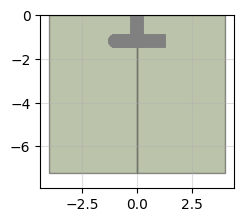

In [10]:
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column, build=False)
model.plot()

The `build()` method creates the model in Plaxis so it can be used. 

In [11]:
model.build()

## Geometry

### Model types

There are 4 model types classified by the way in which the foundation structure is modeled (plate elements or solid polygons) and the geometry (symmetric and non-symmetric models):

- ``Plate``: Non-symetric plate model.
- ``SPlate``: Symetric plate model.
- ``Solid``: : Non-symetric solid model.
- ``SSolid``: : Symetric solid model.

In a symmetric model only half of the foundation is build in Plaxis, with the other half assumed to be a mirror image. Consequently in symmetric models the column is always centered in the foundation, and only vertical loads can be applied. The following code creates four models in Plaxis. These four models represent the same strip foundation with a centered column with either plates or a solid and in full or only half:

In [ ]:
d = 1.2 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg


# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

# elastic material for concrete with equivalent stiffness than the column and footing
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# Model creation (run one at the time)
model1 = ltest.SPlate(s_i, g_i, g_o, b, d, soil, footing, column, model_type='planestrain')
model2 = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column, model_type='planestrain')
model3 = ltest.SSolid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete, model_type='planestrain')
model4 = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete, model_type='planestrain')

The resulting models look like:

<img src="images/models.png" alt="Model types." width="700">

Both symmetric and non-symmetric model can be [plane-strain or axisymmetric in Plaxis](#General-model-settings). A symmetric plane-strain model represents a strip foundation with centered column. A symmetric axisymmetric model represents a circular foundation also with a centered column. Non-symmetric plane-strain model represents a strip foundation, with the advantage that [the column does not need to be centered](#Column-offset) in the foundation and that not only vertical, but also [horizontal and moment loads](#Load-test) can be applied to the foundation. A non-symmetric axisymmetric model represents a ring foundation, for example under a tank or silo. As with the plane-strain case, not only vertical, but horizontal and moment loads can be applied and the column does not need to be centered.

When the column is centered in the foundation and only vertical loads are of interest, the ``SPlate`` and ``SSolid`` are preferable as they required half the number of elements and thus are much faster to run. Although [shake tests](#Shake-test) can be performed in ``SPlate`` and ``SSolid`` models, they do not have a valid physical interpretation as they would imply the soil stretching outwards and contracting from the axis of the foundation. The same happens in ``Plate`` and ``Solid`` models if they are axisymmetric.

### Solid foundations

Solid foundations model the foundation structure as a solid polygon instead of a plate. A soil material must be provided for the foundation material.

In [12]:
# Geometry
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

The resulting model is:

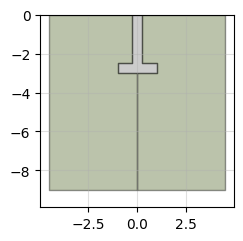

In [13]:
model.plot()

### Column offset

The column offset in ``Plate`` and ``Solid`` models is controlled with the ``b2`` argument that represents the distance from the left edge of the footing to the column axis. In ``Solid`` models the column width ``b1`` is included in the geometry, which limits ``b2`` in  $b_1 /\ 2 \leq b_2 \leq b - b_1 /\ 2$. In ``Plate`` models the axis of the column can be located at the edge of the footing plate, so $0 \leq b_2 \leq b$.

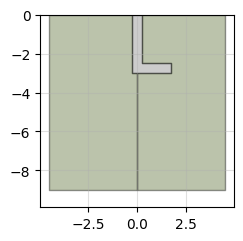

In [15]:
# Geometry
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width
b2 = 0.25 # distance from the left edge of the footing to the center of the column

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete, b2=b2)
model.plot()

The same model with plate structure is created with:

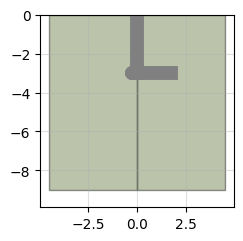

In [17]:
# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

# build model
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column, b2=b2)
model.plot()

### Surface foundations

A surface foundation is created by setting the depth to 0. If the foundation is modeled by plate elements, no material need to be provided for the column:

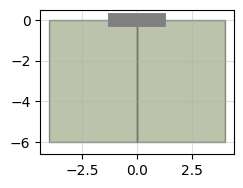

In [4]:
d = 0 # Foundation depth
b = 2 # Foundation width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Create with f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)
column = None

# Create model
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column)
model.plot()

If the foundation is modeled as a solid, the column width is still required as the width of the applied uniform load on top of the foundation.

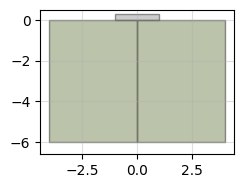

In [2]:
# Geometry
d = 0 # Foundation depth
b = 2 # Foundation width
b1 = 0.6 # Load width
d1 = 0.3 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)
model.plot()

Solid foundations can be partially embedded:

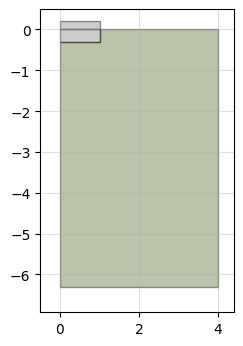

In [3]:
# Geometry
d = 0.3 # Foundation depth
b = 2 # Foundation width
b1 = 0.6 # Load width
d1 = 0.5 # Foundation width

# build model
model = ltest.SSolid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)
model.plot()

### Stratification

Multiple soil layers are defined by providing a soil material for each layer and specify each layer thickness with the `dstrata` parameter. If the model height exceeds the combined height of the individual layers, the bottom layer is extended.

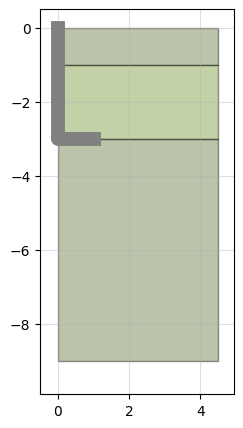

In [5]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb top soil material
top_layer = {}
top_layer['SoilModel'] = 'mohr-coulomb'
top_layer["DrainageType"] = 0
top_layer['gammaSat'] = 20 # kN/m3
top_layer['gammaUnsat'] = 17 # kN/m3
top_layer['e0'] = 0.2
top_layer['Eref'] = 4e4 # kN
top_layer['nu'] = 0.2
top_layer['cref'] = 0 # kPa
top_layer['phi'] = 30 # deg
top_layer['psi'] = 0 # deg

# Mohr-Coulomb second soil material
mid_layer = {}
mid_layer['SoilModel'] = 'mohr-coulomb'
mid_layer["DrainageType"] = 0
mid_layer['gammaSat'] = 20 # kN/m3
mid_layer['gammaUnsat'] = 17 # kN/m3
mid_layer['e0'] = 0.2
mid_layer['Eref'] = 4e4 # kN
mid_layer['nu'] = 0.2
mid_layer['cref'] = 0 # kPa
mid_layer['phi'] = 32 # deg
mid_layer['psi'] = 0 # deg

# Mohr-Coulomb second soil material
bottom_layer = {}
bottom_layer['SoilModel'] = 'mohr-coulomb'
bottom_layer["DrainageType"] = 0
bottom_layer['gammaSat'] = 20 # kN/m3
bottom_layer['gammaUnsat'] = 17 # kN/m3
bottom_layer['e0'] = 0.2
bottom_layer['Eref'] = 4e4 # kN
bottom_layer['nu'] = 0.2
bottom_layer['cref'] = 0 # kPa
bottom_layer['phi'] = 39 # deg
bottom_layer['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

# build model
model = ltest.SPlate(s_i, g_i, g_o, b, d,
                     [top_layer, mid_layer, bottom_layer], footing, column,
                     dstrata=[1, 2, 3])
model.plot()

### Fill

The fill material used in buried foundations is included in the model by provided a soil material in the `fill` argument and the excavation slope (in degrees) in the `fill_angle` argument. The model includes the initial phase with only the original stratigraphy, an excavation phase where the soil material is removed, and a construction phase where the foundation and the fill are activated.

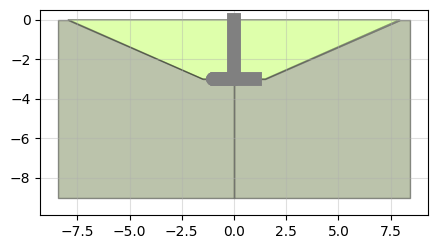

In [7]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb top soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 30 # deg
soil['psi'] = 0 # deg

# Mohr-Coulomb second soil material
fill = {}
fill['SoilModel'] = 'mohr-coulomb'
fill["DrainageType"] = 0
fill['gammaSat'] = 20 # kN/m3
fill['gammaUnsat'] = 17 # kN/m3
fill['e0'] = 0.2
fill['Eref'] = 4e4 # kN
fill['nu'] = 0.2
fill['cref'] = 0 # kPa
fill['phi'] = 32 # deg
fill['psi'] = 0 # deg


# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

# build model
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, column, footing, fill=fill, fill_angle=25)

model.plot()

The `nfill` parameter generates multiple fill layers of equal thickness. A list of soil materials for each layer must be provided, from top to bottom. 

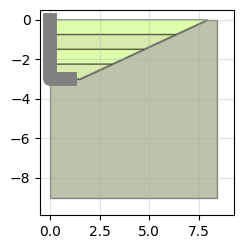

In [8]:
model = ltest.SPlate(s_i, g_i, g_o, b, d, soil, footing, column,
                     nfill=4, fill=[fill,fill,fill,fill],
                     fill_angle=25)
model.plot()

The `dfill` parameter generates fill layers of the requested thickness. If the cumulative thickness of the fill layers is below the foundation depth, and additional layer is added.

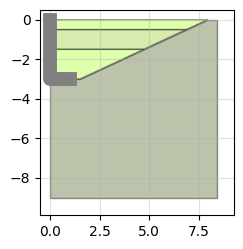

In [9]:
model = ltest.SPlate(s_i, g_i, g_o, b, d, soil, footing, column,
                     dfill=[0.5, 1], fill=[fill,fill,fill], fill_angle=25)
model.plot()

The `bfill` parameter controls the distance between the edge of the foundation and the start of the fill slope.

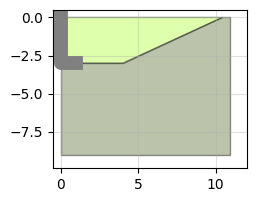

In [10]:
model = ltest.SPlate(s_i, g_i, g_o, b, d, soil, footing, column,
                     fill=[fill], fill_angle=25, bfill=3)
model.plot()

### Water table

The `wt` parameter specifies the global water table of the model, which is applied to all stages.

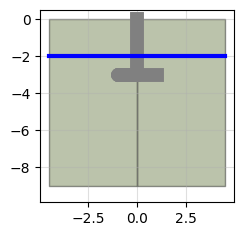

In [11]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

# initialize model
model = ltest.Plate(s_i, g_i, g_o, b, d, soil, footing, column, wt=2)

# plot
model.plot()

### Output locations

When a [test](#Foundation-tests) is conducted, displacements are retrieved at several points in the foundation. This locations include the top of the column (or the top of the slab in a surface foundation) and several points in the bottom of the footing. The location of these points in the model is defined with the `location` parameter. Values between -1 and 1 are admitted, with -1 representing the left edge of the foundation, 0 the column axis and 1 the right edge. The default output locations at the bottom of the foundation are `[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]`.

The position of the output locations can be seen in the foundation plot:

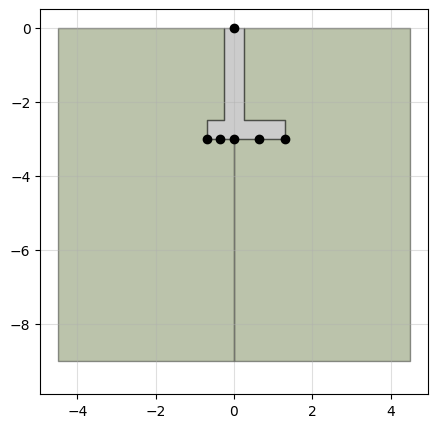

In [6]:
# Geometry
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width
b2 = 0.7 # column location

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
self = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete, build=False,
                   b2=b2, locations=[-1, -0.5, 0, 0.5, 1])

self.plot(output_location=True, figsize=5)

### Interfaces

By default an interface is included between the column and the soil. Additional interfaces can be included in the top and bottom of the footing and, for the solid foundation, on its side as well. Interfaces are controlled through the `interface` argument. If set to `True` all interfaces will be activated. Likewise, if set to `False` all interfaces are deactivated. Individual activations are handled via a dictionary with keys `'column'`, `'top'`, `'bottom'` and `'lateral'`.

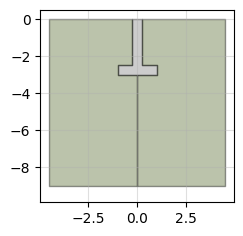

In [12]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete,
                    interface={'lateral':True, 'bottom':True})

# plot
model.plot()

### Model size

The `model_width` and  `model_depth` parameters control the extent of the model.

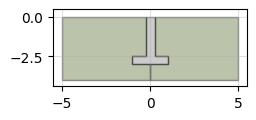

In [13]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete,
                    model_width=10, model_depth=4)

# plot
model.plot()

## Materials

### Soil materials

#### Linear elastic

Linear elastic soil materials are specified by a dictionary whit the following fields:

In [14]:
material = {}
material['SoilModel'] = 'elastic'
material["DrainageType"] = 0
material['Eref'] = 728e3 # kPa
material['nu'] = 0.4 #
material['gammaSat'] = 17
material['gammaUnsat'] = 20

There are optional parameters that, if not provided, the default value calculated by Plaxis is assigned:

In [15]:
material['Rinter'] = 0.5  # interface strength, default value 1
material['kx'] = 0.02 # [m/day] Permeability in the horizontal direction, default value 0
material['ky'] = 0.04 # [m/day] Permeability in the vertical direction, default value 0
material['RayleighAlpha'] = 0.57 # Rayleight damping alpha parameter, default value 0
material['RayleighBeta'] = 0.2  # Rayleight damping beta parameter, default value 0

#### Mohr-Coulomb

Mohr-Coulomb soil materials are specified by a dictionary whit the following fields:

In [16]:
# Mohr-Coulomb soil material
material = {}
material['SoilModel'] = 'mohr-coulomb'
material["DrainageType"] = 0
material['gammaSat'] = 20 # kN/m3
material['gammaUnsat'] = 17 # kN/m3
material['e0'] = 0.2
material['Eref'] = 4e4 # kN
material['nu'] = 0.2
material['cref'] = 0 # kPa
material['phi'] = 35 # deg
material['psi'] = 0 # deg

There are optional parameters that, if not provided, the default value calculated by Plaxis is assigned:

In [17]:
soil['Rinter'] = 0.5 # interface strength, default value 1
soil['K0nc'] = 0.6 # default value sin(45 - phi / 2)
soil['kx'] = 0.02 # [m/day] Permeability in the horizontal direction, default value 0
soil['ky'] = 0.04 # [m/day] Permeability in the vertical direction, default value 0
material['RayleighAlpha'] = 0.57 # Rayleight damping alpha parameter, default value 0
material['RayleighBeta'] = 0.2  # Rayleight damping beta parameter, default value 0

#### Hardening soil

Hardening soil materials are specified by a dictionary whit the following fields:

In [18]:
material = {}
material['SoilModel'] = 'hardening soil'
material["DrainageType"] = 0
material['gammaSat'] = 17
material['gammaUnsat'] = 20
material['e0'] = 0.2
material['E50ref'] = 4e4
material['Eoedref'] = 4e4
material['Euref'] = 1.2e5
material['powerm'] = 0.5
material['c'] = 0
material['phi'] = 32
material['psi'] = 2
material['nu'] = 0.2

There are optional parameters that, if not provided, the default value calculated by Plaxis is assigned:

In [19]:
material['Rinter'] = 0.5 # interface strength, default value 1
material['K0nc'] = 0.6 # default value sin(45 - phi / 2)
material['kx'] = 0.02 # [m/day] Permeability in the horizontal direction, default value 0
material['ky'] = 0.04 # [m/day] Permeability in the vertical direction, default value 0
material['RayleighAlpha'] = 0.57 # Rayleight damping alpha parameter, default value 0
material['RayleighBeta'] = 0.2  # Rayleight damping beta parameter, default value 0

### Plate materials

Plate materials are specified by a dictionary whit the following fields:

In [20]:
plate_material = {}
plate_material['nu'] = 0.4
plate_material['EA'] = 7.73e6 # KPa m
plate_material['EI'] = 0.3**2 / 12 * 7.73e6 # KPa m
plate_material['d'] = 0.3 # m
plate_material['Gref'] = 7.73e6 / (2 * 0.3 * (1 + 0.4)) # KPa

There are optional parameters that, if not provided, the default value calculated by Plaxis is assigned:

In [21]:
plate_material['RayleighAlpha'] = 0.57 # Rayleight damping alpha parameter, default value 0
plate_material['RayleighBeta'] = 0.2  # Rayleight damping beta parameter, default value 0

Plates material are specified per m of cross-section width. Therefore, the stiffness parameters must comply with the following relations. The equivalent thickness `d` is related to the axial and flexural stiffness by:

$$d=\sqrt{12 \frac{EI}{EA}}$$

The reference shear modulus:

$$G_{ref} = \frac{EA}{2 \ d \ \left(1 + \nu \right)}$$

An alternative way to define a plate material is using the `concrete function`, where the properties of the plate are computed form the compressive strength of concrete as:

$$E \left[kPa\right] = 4700 \ \sqrt{f'_c} \ 10^3$$

$$EA = E \ d \ 1m$$

$$EI = E \ \frac{d^3 \ 1m}{12}$$

$$w = \gamma \ d \ 1m $$

The default value for the Poisson modulus can be modified when calling the function:

In [22]:
fc = 30 # MPa
gamma = 24 #kN/m3
d = 0.4
ltest.concrete(fc, gamma, d, poisson=0.3)

{'fc': 30,
 'E': 25742960.202742808,
 'nu': 0.3,
 'EA': 10297184.081097124,
 'EI': 137295.78774796167,
 'd': 0.4,
 'Gref': 9901138.539516464,
 'gamma': 24,
 'w': 9.600000000000001}

## Foundation tests

### Load test

The `load_test` method conducts a static load test consisting of consecutive load levels being applied to the foundation. Symmetric foundations only allow for vertical loads, while non-symmetric foundations can be subjected to shear and moment loads. The loads are applied at the surface level, except in [surface or partially embedded solid foundations](#Surface-foundations) where the load is applied at the top of the foundation slab. Positive load values imply:

<img src="images/signs.png" alt="Bouc-Wen SDOF." width="300">

#### Symmetric models

In a [symmetric model](#Model-types) loads values are specified by an array, as only vertical loads are possible: 

In [12]:
# Geometry
d = 2 # Foundation depth
b = 3 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.SSolid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

# load test
testid = 'test A'
loads = [-60, 30, -60, 20]
model.load_test(testid, loads)

The `plot_test` method generates a figure with the load test. By default, the plot includes all [output locations](#Output-locations) and stages of the test:

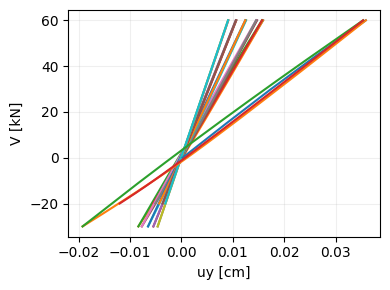

In [13]:
model.plot_test('test A')

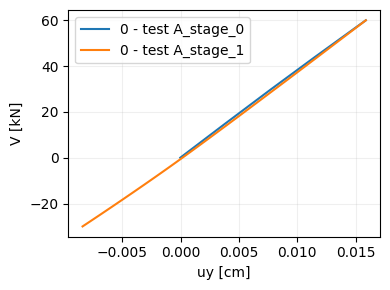

In [14]:
model.plot_test('test A', location=[0], phase=[0, 1], legend=True)

`compression_positive` controls the sign of the vertical force axis. If `True` compression forces are plotted as positive. `pullout_positive` controls the sign of the displacement axis. If `True` then pull-out displacements are positive.

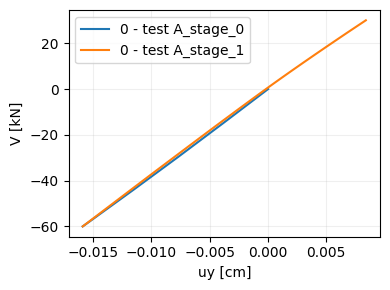

In [15]:
model.plot_test('test A', location=[0], phase=[0, 1], legend=True,
                compression_positive=False, pullout_positive=True)

#### Non-symmetric model

In a [non-symmetric model](#Model-types) loads values are specified as 3-element arrays, with their components being Fy, Fx and M. For example, a test consisting of first applying a vertical compressive load, and then a horizontal force and a moment while keeping the compressive force active, and finally removing the horizontal and compressive load is created by:

In [2]:
# Geometry
d = 2 # Foundation depth
b = 3 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

# load test
testid = 'test A'
loads = [[-100, 0, 0],  # first stage, apply compressive load
         [-100, 40, 100], # second stage, apply horizontal load and moment
         [-100, 0, 0]] # Third stage, remove horizontal load and moment
model.load_test(testid, loads)

Results are visualized with the `plot_test` method.

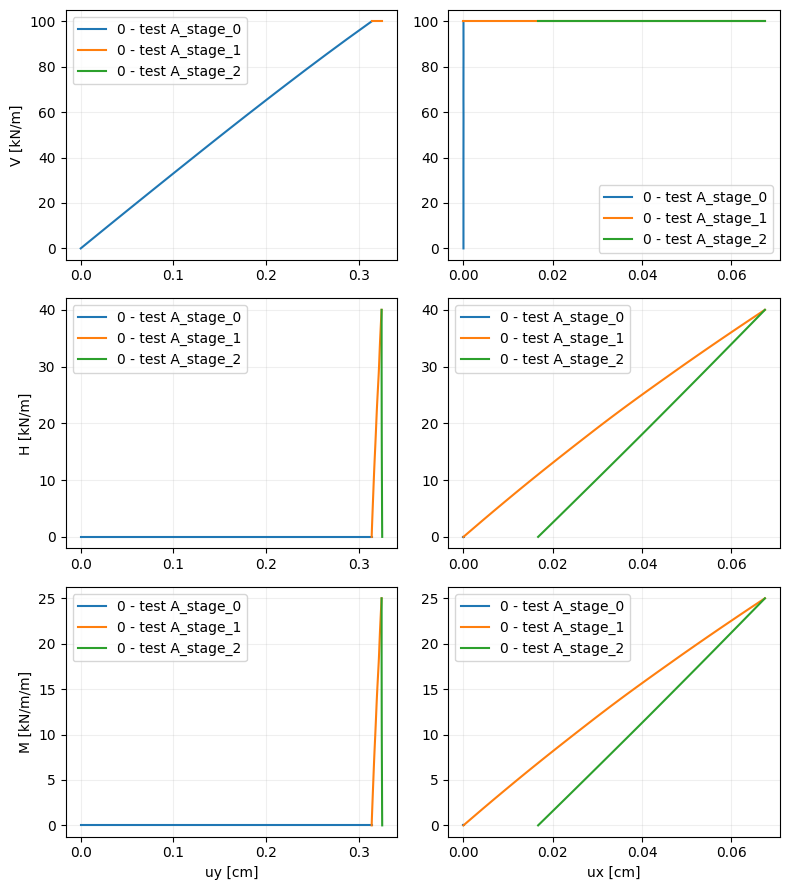

In [3]:
model.plot_test('test A', location=0, legend=True)

The displacement and force components to plot are selected with the `force` and `displacement` arguments:

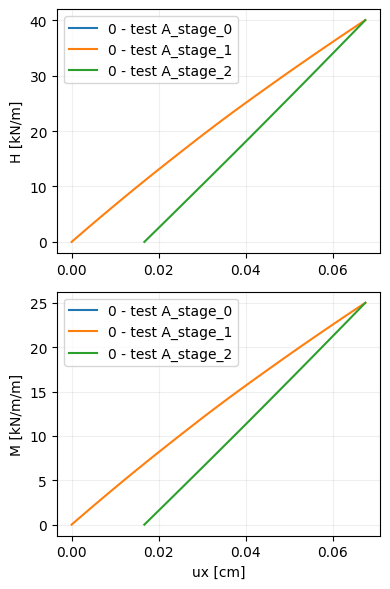

In [4]:
model.plot_test('test A', location=0, force=['Fx', 'M'], displacement='ux', legend=True)

### Failure test

The `failure_test` method increases the applied load until the model ceases to converge. A first trial is done using the `load` value provided. If lack of convergence is not achieved, the load is incremented as `load = load_factor * load + load_increment`. The format in which loads are defined for [symmetric and non-symmetric](#Model-types) models is the same than in the [load test](#Load-test).

#### Symmetric model

In [2]:
# Geometry
d = 2 # Foundation depth
b = 3 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.SSolid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

Failure test under compression:

In [3]:
testid = 'failure - compression'
load = -1600
model.failure_test(testid, load)

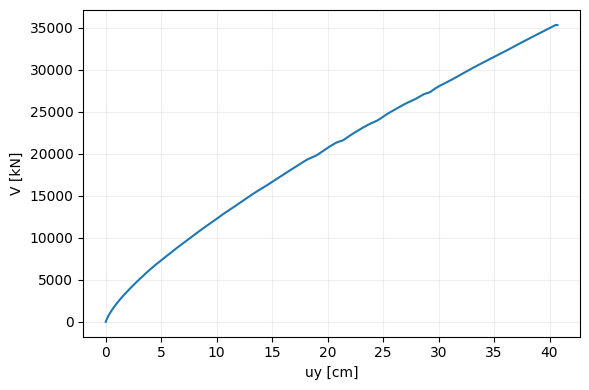

In [5]:
model.plot_test('failure - compression', location=0, figsize=(6, 4))

Failure test under pull-out:

In [6]:
testid = 'failure - pullout'
load = 1000
model.failure_test(testid, load)

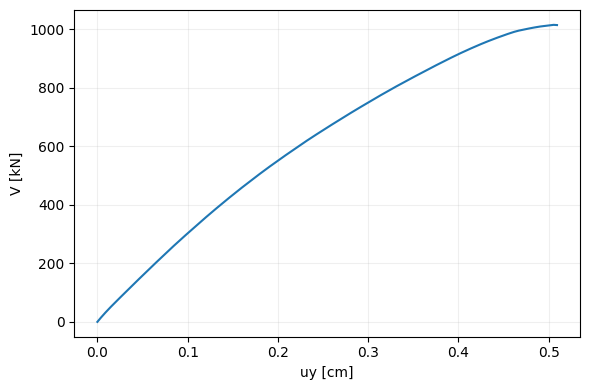

In [9]:
model.plot_test('failure - pullout', location=0, figsize=(6, 4),
                pullout_positive=True, compression_positive=False)

#### Non-symmetric model

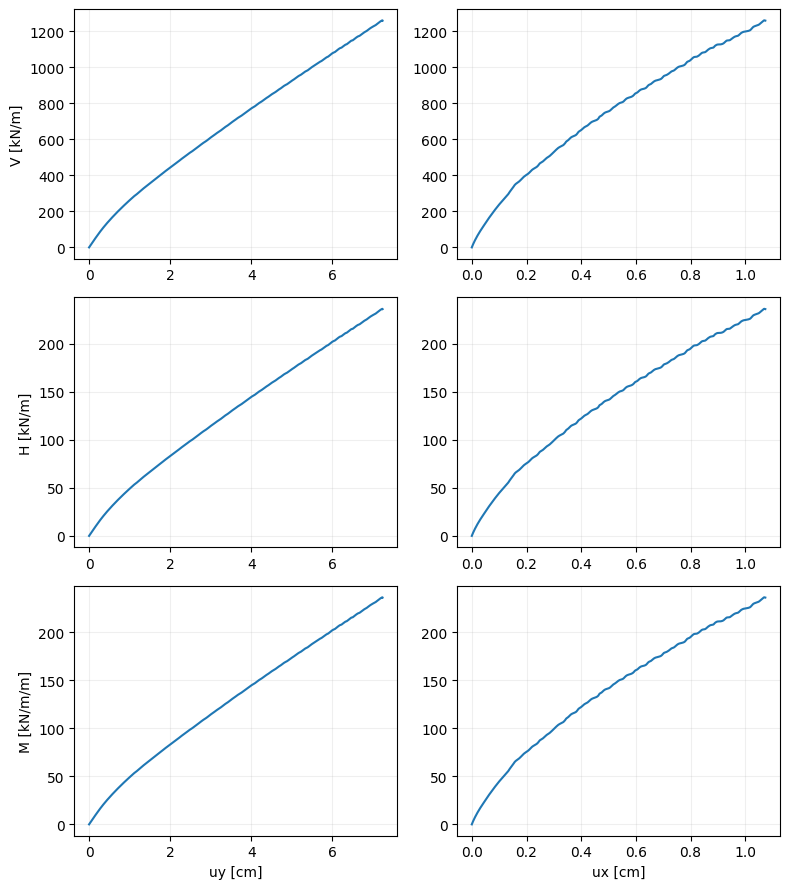

In [5]:
# Geometry
d = 2 # Foundation depth
b = 3 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

# failure test
testid = 'failure'
load=[-1600, 300, 1200]
model.failure_test(testid, load)

model.plot_test('failure', location=0)

### Safety tests

The `safety_test` creates a safety calculation phase. The converged state from which the safety test starts is set with the [start phase](#Start-phase). Two types of tests are supported: incremental and target tests. In an incremental test the strength reduction factor $\sum Msf$ is reduced until convergence fails. The reduction step is set with the `Msf` parameter. In a target test the reduction factor is reduced up to a certain target, the target value is set with the `SumMsf` parameter. Results can be visualized with the `plot_safety` method.

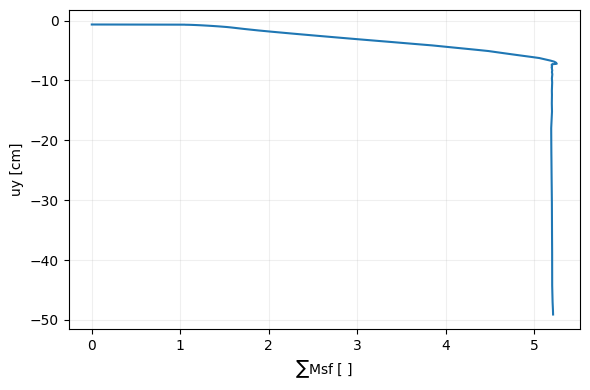

In [14]:
# Geometry
d = 2 # Foundation depth
b = 3 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.SSolid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

# create a test to apply a load in the foundation
test_id = 'dead load'
load = -1600
model.load_test(test_id, load)

# incremental test
test_id = 'safety incremental'
start_from='dead load'
model.safety_test(test_id, start_from, test='incremental', Msf=0.2)

# plot resutls
model.plot_safety_test('safety incremental', location=0)

For a target test:

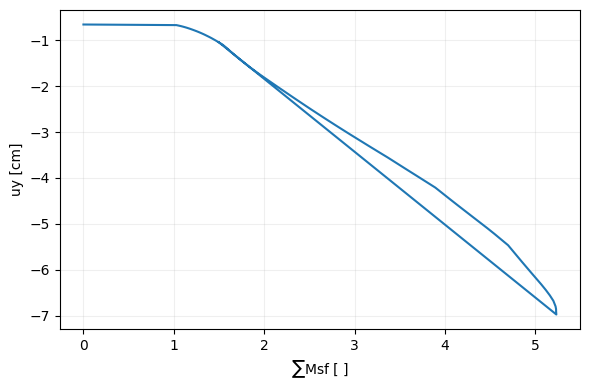

In [16]:
# target test
test_id = 'safety target'
start_from='dead load'
model.safety_test(test_id, start_from, test='target', SumMsf=1.5)

# plot resutls
model.plot_safety_test('safety target', location=0)

### Dynamic load test

The `dynamic_test` method applies a dynamic load to the model. The load is defined by a time array and an array with the force components at each instant. The force array has (ncomp, nt) elements, where ncomp is the number of force components and nt is the number of samples across time. In a [solid model](#Solid-foundations) only vertical "Fy" and horizontal "Fx" forces can be applied. In a plate model moments "M" can also be applied. The order in which the force components is specified in the force array is Fy, Fx and M. If only Fy is provided, the other components are assumed as 0.

[Symmetric](#Model-types) models only admit vertical loads. 

In [4]:
# Package import
import numpy as np

# Geometry
d = 2 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

# dynamic test
testid = 'dyn'
time = np.arange(0, 3, 0.03)
load = -10 * np.sin(2 * np.pi * time)
model.dynamic_test(testid, time, load)

The `plot_test` function can be used to show the load-displacement across time: 

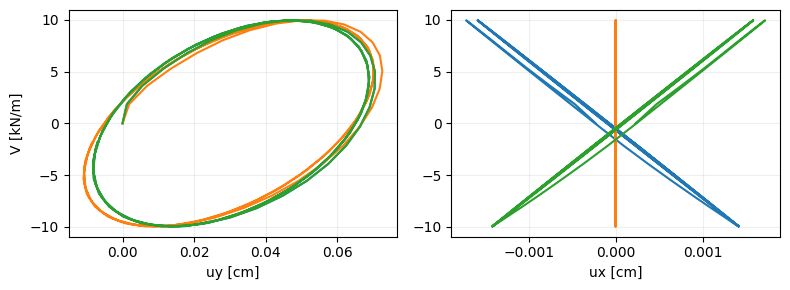

In [5]:
testid = 'dyn'
model.plot_test(testid, location=[-1, 0, 1], force='Fy')

The `plot_dynamic_test` method shows the variation with time of the displacement and force components.

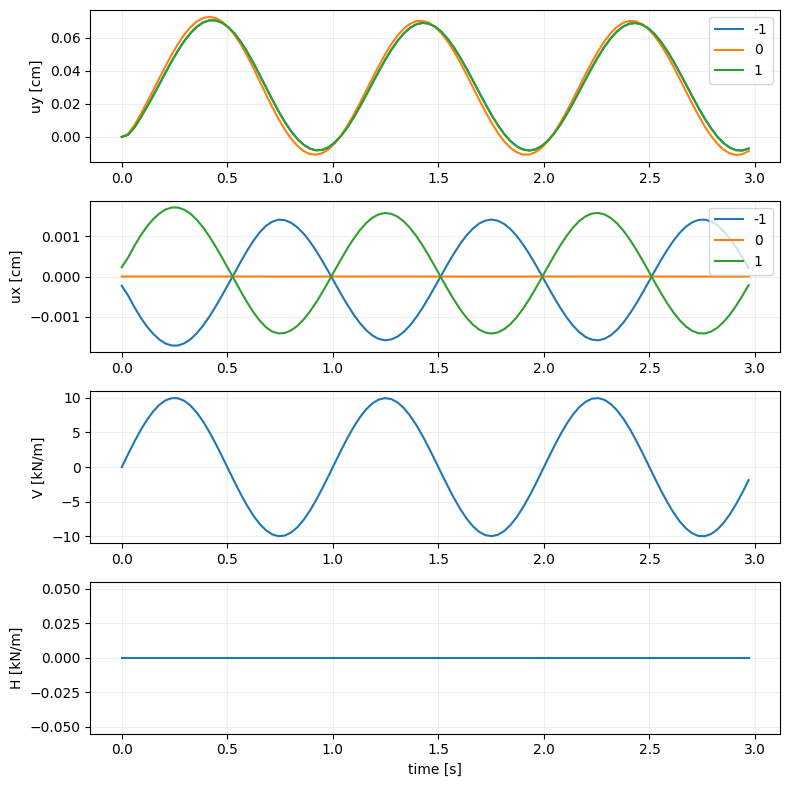

In [6]:
testid = 'dyn'
model.plot_dynamic_test(testid, location=[-1, 0, 1], legend=True)

Displacement and force components are selected with the `displacement` and `force` arguments:

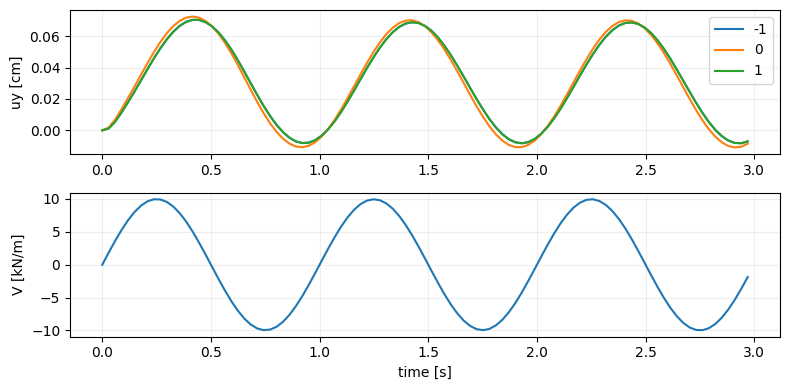

In [7]:
testid = 'dyn'
model.plot_dynamic_test(testid, displacement='uy', force='Fy',
                        location=[-1, 0, 1], legend=True)

### Shake test

The `shake_test` method conducts a ground shaking test where a displacement time history is imposed on the base of the model. Base excitation of a model requires that interfaces are placed around the edges of the mesh. Although these interfaces are not activated, they increase the mesh density significantly, increasing the computation costs for all tests. Therefore, they are not included in the models by default and should be requested when creating a model by setting the `boundary_interface` parameter to `True`.

The difference in meshing density can be appreciated below:

<img src="images/bounday_interface_mesh.png" alt="Boundary interface effect on mesh." width="500">

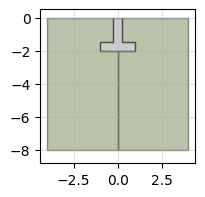

In [2]:
# Package import
import numpy as np

# Geometry
d = 2 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.Solid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete, boundary_interface=True)
model.plot(figsize=2)

The `shake_test` method requires as an input a discretization of the acceleration that will be imposed at the base. The discretization is given by a time array and an acceleration array with as many elements of the time array. If the acceleration array is one dimensional, it is assumed to be the horizontal acceleration. A 2-dimensional array of (2, nt) elements can be provided, where the first row is the horizontal acceleration and the second the vertical acceleration.

In [3]:
testid='shake'
time = np.arange(0, 3, 0.03)
acceleration = 0.2 * np.sin(2 * np.pi * time)
model.shake_test(testid, time, acceleration)

The `plot_shake_test` method shows the variation with time of the foundation displacement and base acceleration.

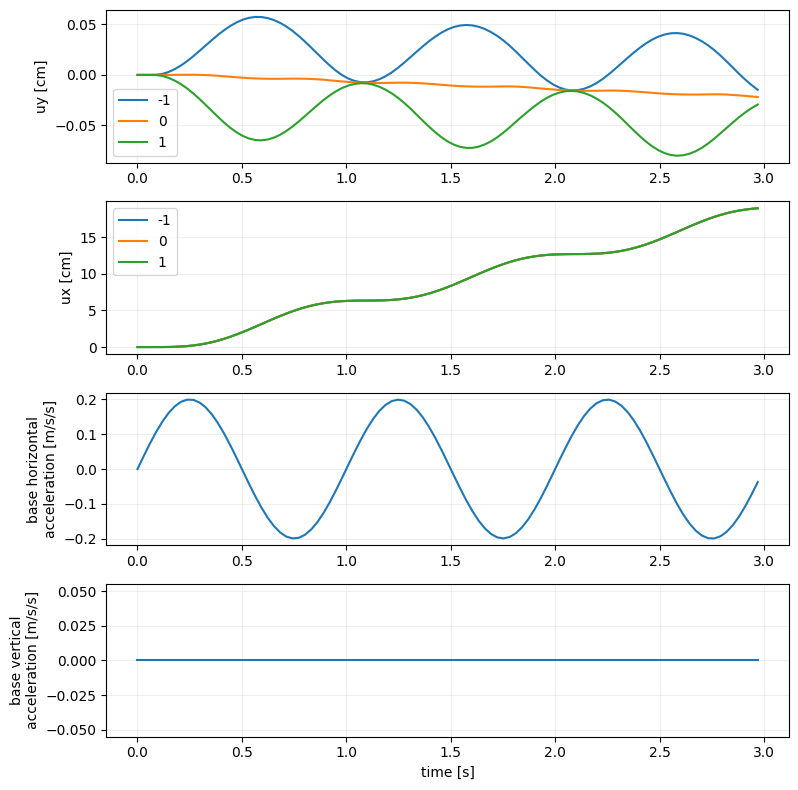

In [8]:
testid = 'shake'
model.plot_shake_test(testid, location=[-1, 0, 1], legend=True)

Displacement and acceleration components are selected with the `displacement` and `acceleration` arguments:

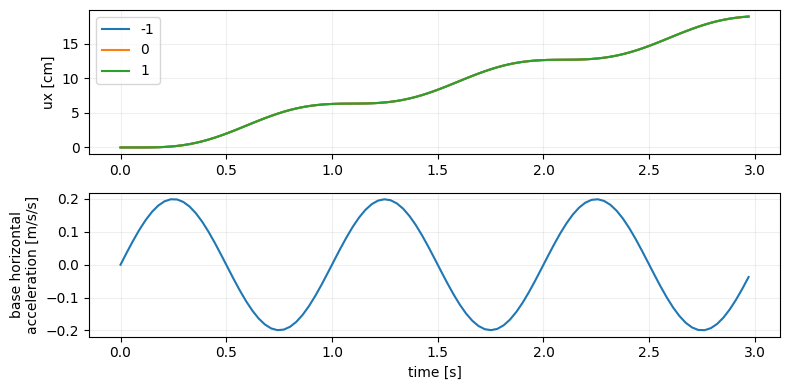

In [7]:
testid = 'shake'
model.plot_shake_test(testid, displacement='ux', acceleration='agx',
                      location=[-1, 0, 1], legend=True)

### Surface load

In all tests, the `qsurf` parameter imposes a uniformly distributed surface load. This load is applied in a separate phase before the rest of test is conducted. As with the loads acting on the foundation, compression is indicated by a negative value.

The following example conducts the same load test with and without a surface load, and compares the results.

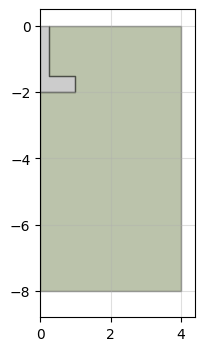

In [13]:
# Geometry
d = 2 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.SSolid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)
model.plot(figsize=2)

In [14]:
# load test without surface load
testid = 'test w/o qsurf'
loads = -600
model.load_test(testid, loads)

# load test with surface load
testid = 'test w. qsurf'
model.load_test(testid, loads, qsurf=-100)

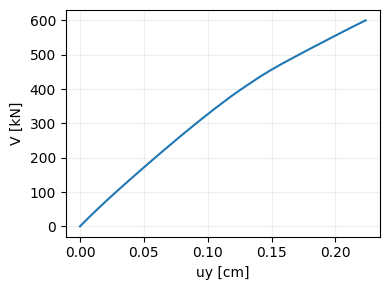

In [15]:
model.plot_test('test w/o qsurf', location=0, displacement='uy', force='Fy')

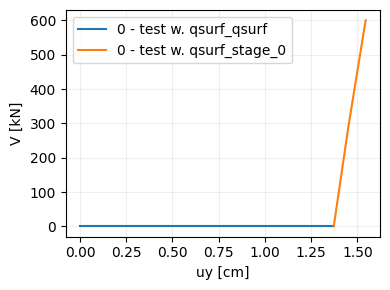

In [18]:
model.plot_test('test w. qsurf', location=0, 
                displacement='uy', force='Fy', legend=True)

We can select to plot only the load phase to compare to the case without the surface load. By setting `reset_start` to `True` the plot starts from (0,0). As it can be seen, there is a significant difference in the load-displacement behavior.

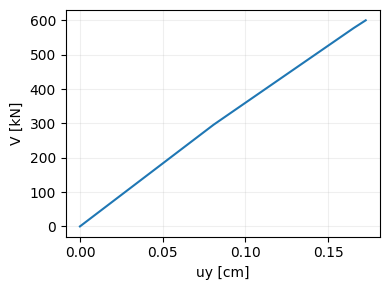

In [19]:
model.plot_test('test w. qsurf', location=0, 
                displacement='uy', force='Fy',
                phase='test w. qsurf_stage_0', reset_start=True)

### Start phase

By default, all tests types are conducted starting from the construction phase of the model. This can be changed with the `start_from` parameter. If a existing test id is provided, then the new test is performed after the last stage of the selected test.

In [ ]:
# Geometry
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# build model
model = ltest.SSolid(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

# load test
testid = 'test A'
loads = [-60, 30, -40]
model.load_test(testid, loads)

To start from the last phase of `'test A'`:

In [ ]:
# load test
testid = 'test B'
loads = [40]
model.load_test(testid, loads, start_from='test A')

An specific stage of a test can be selected by providing a tuple with the test id and the stage number (starting from 0). For example, `'test A'` hast 3 stages, corresponding to the -60, +30, -40 load values. If the new test is to start from the +30 stage, then `start_from` should be set to `('test A', 1)`.

In [ ]:
# load test
testid = 'test C'
loads = [40]
model.load_test(testid, loads, start_from=('test A', 1))

Failure and safety test cannot be used as starting stages of a new test, since the model has ceased to converge.

### Delete test

The `delete_test` method removes tests from both the results table and Plaxis. If `delete_phases` is set to `False` the calculation phases in Plaxis are kept.

In [ ]:
model.delete_test('test C')